# Zyfra

## Descripcion del proyecto

Preparar un prototipo de un modelo de machine learning para Zyfra. La empresa desarrolla soluciones de eficiencia para la industria pesada.

El modelo realizara predicciones de la cantidad de oro extraído del mineral de oro. Se disponen de los datos de extracción y purificación.

El modelo ayudará a optimizar la producción y a eliminar los parámetros no rentables.

## Codigo

## 1. Preparacion de datos

In [1]:
# Importar librerias necesarias para el modelo

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import ks_2samp

### 1.1 Abrir archivos y examinar datos

In [2]:
# Leer los data set y guardarlo en la variable data

data_train = pd.read_csv('/datasets/gold_recovery_train.csv')
data_test = pd.read_csv('/datasets/gold_recovery_test.csv')
data_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
# Imprimir la informacion basica para revisar los data set en general y confirmar que esten limpio para el modelo

print('data_train')
print(data_train.info())
print()
print('data_test')
print(data_test.info())
print()
print('data_full')
print(data_full.info())

data_train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-nul

In [4]:
# Imprimir las primeras 5 columnas del data set para conocerlo

print('data_train')
print(data_train.head())
print()
print('data_test')
print(data_test.head())
print()
print('data_full')
print(data_full.head())

data_train
                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501      

In [5]:
# Imprimir un analisis estadistico descriptivo

print('data_train')
print(data_train.describe())
print()
print('data_test')
print(data_test.describe())
print()
print('data_full')
print(data_full.describe())

data_train
       final.output.concentrate_ag  final.output.concentrate_pb  \
count                 16788.000000                 16788.000000   
mean                      4.716907                     9.113559   
std                       2.096718                     3.389495   
min                       0.000000                     0.000000   
25%                       3.971262                     8.825748   
50%                       4.869346                    10.065316   
75%                       5.821176                    11.054809   
max                      16.001945                    17.031899   

       final.output.concentrate_sol  final.output.concentrate_au  \
count                  16490.000000                 16789.000000   
mean                       8.301123                    39.467217   
std                        3.825760                    13.917227   
min                        0.000000                     0.000000   
25%                        6.939185          

### 1.2 Comprobacion del calculo de recuperacion

In [6]:
# Extraer las columnas necesarias para el calculo
c = data_train['rougher.output.concentrate_au']
f = data_train['rougher.input.feed_au']
t = data_train['rougher.output.tail_au']

# Usar la formula de recuperacion, asegurandose de evitar divisiones por cero
recovery_calc = (c * (f - t)) / (f * (c - t)) * 100

# Crear una mascara para eliminar filas con NaN o valores invalidos
mask = c.notna() & f.notna() & t.notna() & data_train['rougher.output.recovery'].notna()

# Aplicar la mascara
recovery_real = data_train.loc[mask, 'rougher.output.recovery']
recovery_pred = recovery_calc[mask]

# Calcular el EAM entre el valor calculado y el valor real
mae = mean_absolute_error(recovery_real, recovery_pred)
print(f'EAM (Error Absoluto Medio) entre recuperación real y calculada: {mae:.4f}')

EAM (Error Absoluto Medio) entre recuperación real y calculada: 0.0000


In [7]:
# Comparar los primeros valores reales vs. calculados
comparison = pd.DataFrame({
    'real': recovery_real,
    'calculado': recovery_pred
})

print(comparison.head(10))


        real  calculado
0  87.107763  87.107763
1  86.843261  86.843261
2  86.842308  86.842308
3  87.226430  87.226430
4  86.688794  86.688794
5  88.156912  88.156912
6  88.168065  88.168065
7  87.668336  87.668336
8  87.035862  87.035862
9  87.650868  87.650868


La recuperacion calculada usando la formula coincide exactamente con los valores presentes en la columna rougher.output.recovery.
El EAM (Error Absoluto Medio) es 0, lo que indica que los valores son coherentes y fueron generados correctamente.

### 1.3 Comparacion de columnas 

In [8]:
# Comparar columnas de train y test (sin la columna 'date')

train_columns = set(data_train.columns) - {'date'}
test_columns = set(data_test.columns) - {'date'}

# Encontrar columnas que estan en train pero no en test
missing_in_test = train_columns - test_columns

# Ordenarlas alfabeticamente para analizarlas
missing_in_test = sorted(missing_in_test)
print(f"Columnas en train pero NO en test ({len(missing_in_test)}):")
for col in missing_in_test:
    print(col)


Columnas en train pero NO en test (34):
final.output.concentrate_ag
final.output.concentrate_au
final.output.concentrate_pb
final.output.concentrate_sol
final.output.recovery
final.output.tail_ag
final.output.tail_au
final.output.tail_pb
final.output.tail_sol
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_au
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_au
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
rougher.calculation.au_pb_ratio
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.sulfate_to_au_concentrate
rougher.output.concentrate_ag
rougher.output.concentrate_au
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_au
rougher.output.tail_pb
rougher.output.tail_sol
secondary_cleaner.output.tail_ag
secondary_c

### Diferencias entre columnas de `train` y `test`

Al comparar los conjuntos, encontramos **34 columnas presentes en `train` pero no en `test`**.  
Estas diferencias no son un error: tienen una justificación relacionada con el diseño del problema.

Podemos clasificarlas en tres grupos:

1. **Variables objetivo**  
   - `rougher.output.recovery`  
   - `final.output.recovery`  
   Estas son las variables que queremos **predecir**, por eso no aparecen en el conjunto de prueba.

2. **Columnas de cálculo**  
   - Ejemplo: `rougher.calculation.au_pb_ratio`, `rougher.calculation.floatbank10_sulfate_to_au_feed`  
   Son métricas **derivadas de otras columnas**, usadas solo para verificación. No deben usarse como *features* porque no estarán disponibles en producción.

3. **Columnas de salida del proceso (outputs)**  
   - Ejemplo: `rougher.output.*`, `final.output.*`  
   Representan los **resultados de las etapas del proceso** (concentrados y colas).  
   No aparecen en `test` porque son justamente las variables que el modelo debería ayudar a estimar.


### Conclusión
Las columnas que están en `train` pero no en `test` incluyen objetivos, cálculos derivados y salidas del proceso.  
**No deben usarse como variables predictoras** porque no estarán disponibles en la práctica real.  
Para entrenar el modelo, trabajaremos únicamente con las columnas **comunes entre ambos conjuntos** (features válidos).


### 1.4 Procesamiento de datos

In [9]:
# Guardar columnas objetivo por separado
target_columns = ['rougher.output.recovery', 'final.output.recovery']

# Identificar columnas que SI estan tanto en train como en test
train_features = data_train.columns.drop(['date'] + target_columns)
test_features = data_test.columns.drop('date')

# Confirmar que las columnas que vamos a usar son las comunes
common_features = list(train_features.intersection(test_features))

# Construir el dataset de entrenamiento final con columnas validas + objetivos
data_train = data_train[['date'] + common_features + target_columns]

# Eliminar filas con valores faltantes en el conjunto de entrenamiento
data_train = data_train.dropna().reset_index(drop=True)

# Establecer la columna 'date' como indice (util para analisis futuros)
data_train = data_train.set_index('date')
data_test = data_test.set_index('date')
data_full = data_full.set_index('date')

# Confirmacion
print('Preprocesamiento completado:')
print(f'Filas restantes en data_train: {data_train.shape[0]}')
print(f'Columnas utilizadas para entrenamiento: {len(common_features)}')

Preprocesamiento completado:
Filas restantes en data_train: 12679
Columnas utilizadas para entrenamiento: 52


Eliminamos aproximadamente 4,181 filas (de las 16,860 originales) que tenian valores faltantes. Esto es normal y esperado para mantener la calidad del entrenamiento.

## 2. Analisis de datos

### Obersvacion del cambio de concentracion de metales (Au,Ag,Pb)

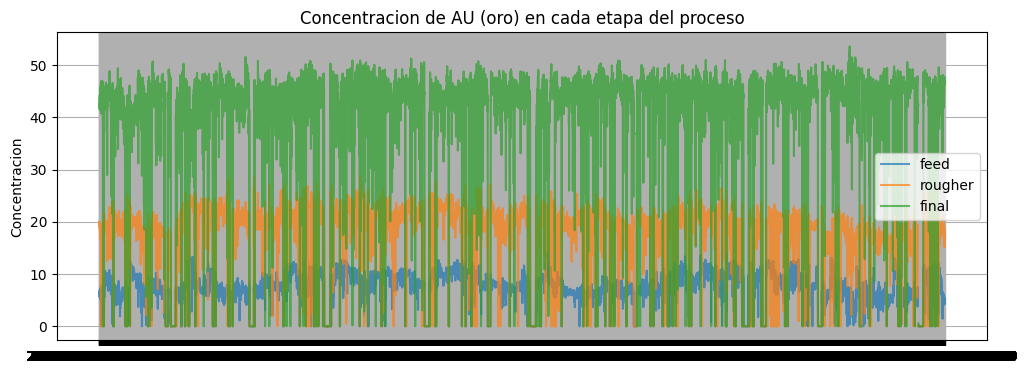

In [10]:
# Grafica concentracion de AU (Oro)

plt.figure(figsize=(12, 4))

plt.plot(data_full['rougher.input.feed_au'], label='feed', alpha=0.7)
plt.plot(data_full['rougher.output.concentrate_au'], label='rougher', alpha=0.7)
plt.plot(data_full['final.output.concentrate_au'], label='final', alpha=0.7)

plt.title('Concentracion de AU (oro) en cada etapa del proceso')
plt.ylabel('Concentracion')
plt.legend()
plt.grid(True)
plt.show()

La concentracion de oro (AU) aumenta progresivamente a lo largo de las etapas del proceso:

De alrededor de 10% en la alimentacion (feed)

A cerca de 30% tras la flotacion (rougher)

Hasta alcanzar valores superiores al 40–50% en el producto final (final)

Esto confirma que el proceso de flotacion y purificacion es efectivo para concentrar el metal deseado.

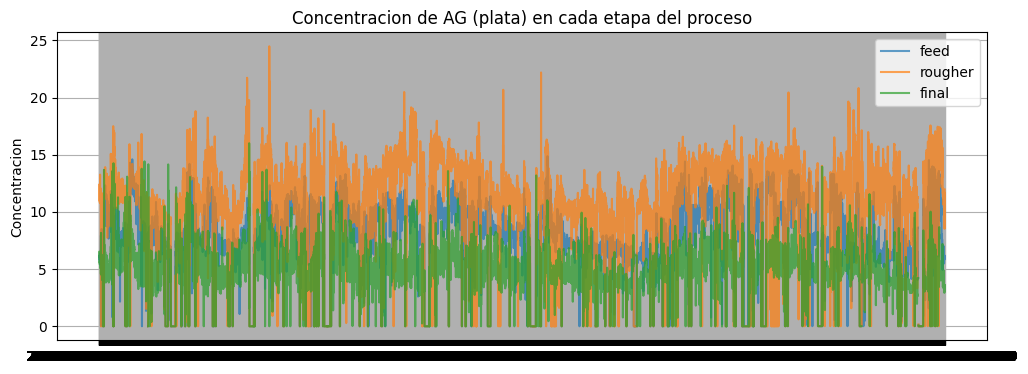

In [11]:
# Grafica concentracion de AG (Plata)

plt.figure(figsize=(12, 4))

plt.plot(data_full['rougher.input.feed_ag'], label='feed', alpha=0.7)
plt.plot(data_full['rougher.output.concentrate_ag'], label='rougher', alpha=0.7)
plt.plot(data_full['final.output.concentrate_ag'], label='final', alpha=0.7)

plt.title('Concentracion de AG (plata) en cada etapa del proceso')
plt.ylabel('Concentracion')
plt.legend()
plt.grid(True)
plt.show()

A diferencia del oro, la concentracion de plata (AG) no aumenta en el proceso.

Aunque hay un ligero incremento tras la flotacion (rougher), la concentracion de AG se reduce en el producto final.

Esto es consistente con el objetivo del proceso, que es maximizar el contenido de oro y reducir impurezas como la plata.

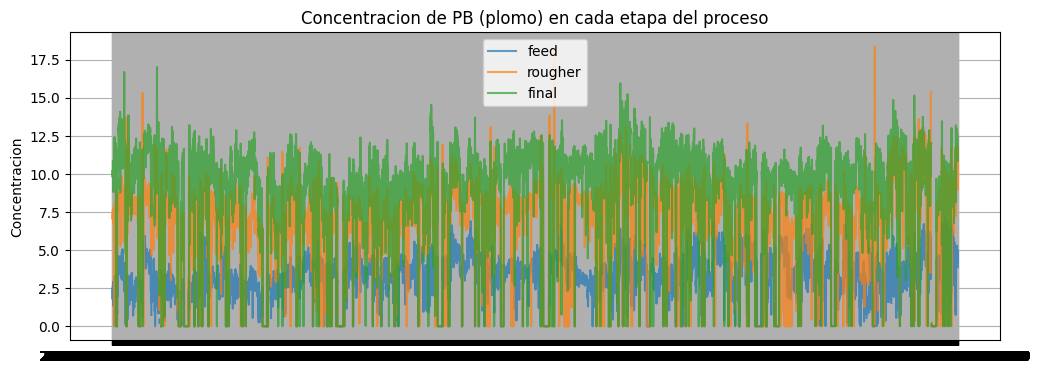

In [12]:
# Grafica concentracion de PB (Plomo)

plt.figure(figsize=(12, 4))

plt.plot(data_full['rougher.input.feed_pb'], label='feed', alpha=0.7)
plt.plot(data_full['rougher.output.concentrate_pb'], label='rougher', alpha=0.7)
plt.plot(data_full['final.output.concentrate_pb'], label='final', alpha=0.7)

plt.title('Concentracion de PB (plomo) en cada etapa del proceso')
plt.ylabel('Concentracion')
plt.legend()
plt.grid(True)
plt.show()

La concentracion de plomo (PB) se mantiene relativamente estable durante el proceso.

A diferencia de la plata, el plomo tiende a concentrarse en el producto final, lo cual puede ser una consecuencia no deseada del proceso. Ya que el objetivo es concentrar oro y eliminar otros metales.

Que el plomo termine en el concentrado final puede indicar que:

No se esta eliminando correctamente

Su separacion es dificil debido a caracteristicas similares al oro

Este resultado sugiere que el modelo debe tener en cuenta los parametros que afectan la separacion de metales pesados como el plomo.

### 2.2 Distribuciones del tamaño de las particulas (Conjunto de entrenamiento y conjunto de prueba)

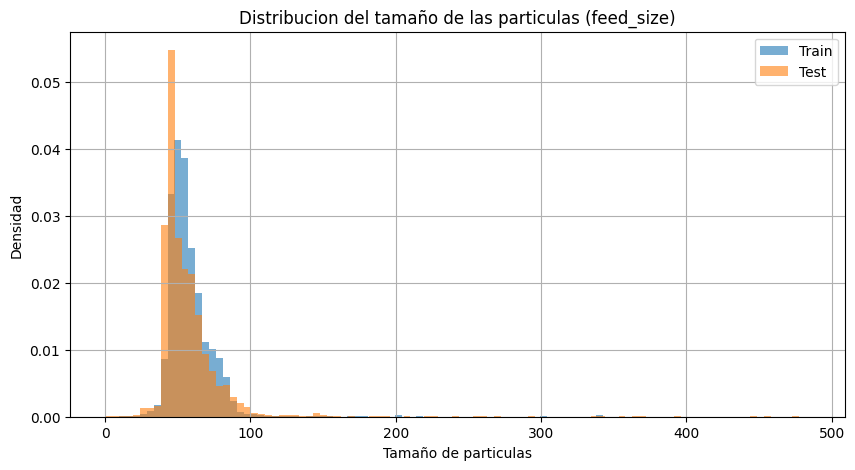

In [13]:
plt.figure(figsize=(10, 5))

# Graficar distribucion en el conjunto de entrenamiento
data_train['rougher.input.feed_size'].plot(kind='hist', bins=100, alpha=0.6, label='Train', density=True)

# Graficar distribucion en el conjunto de prueba
data_test['rougher.input.feed_size'].plot(kind='hist', bins=100, alpha=0.6, label='Test', density=True)

plt.title('Distribucion del tamaño de las particulas (feed_size)')
plt.xlabel('Tamaño de particulas')
plt.ylabel('Densidad')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
# Seleccionar la variable de interés
train_feed = data_train['rougher.input.feed_size'].dropna()
test_feed = data_test['rougher.input.feed_size'].dropna()

# Prueba de Kolmogorov-Smirnov
stat, p_value = ks_2samp(train_feed, test_feed)

print(f"Estadístico KS: {stat:.4f}")
print(f"p-valor: {p_value:.4f}")

if p_value < 0.05:
    print("Diferencia estadísticamente significativa entre las distribuciones (nivel 5%).")
else:
    print("No se detectan diferencias significativas entre las distribuciones (nivel 5%).")


Estadístico KS: 0.2395
p-valor: 0.0000
Diferencia estadísticamente significativa entre las distribuciones (nivel 5%).


### Prueba estadística de comparación de distribuciones

Además de la comparación visual de la variable `feed_size` entre `train` y `test`, realizamos una prueba de **Kolmogorov-Smirnov (KS test)** para evaluar si ambas distribuciones provienen de la misma población.

- **Hipótesis nula (H₀):** Las distribuciones de `feed_size` en `train` y `test` son iguales.  
- **Hipótesis alternativa (H₁):** Las distribuciones son diferentes.  

**Resultados:**  
- Estadístico KS = 0.2395  
- p-valor = 0.0000  

**Interpretación:**  
Dado que el **p-valor < 0.05**, rechazamos la hipótesis nula y concluimos que existen **diferencias estadísticamente significativas** entre las distribuciones de `feed_size` en los conjuntos de entrenamiento y prueba.

Esto implica que el modelo podría enfrentarse a datos con distinta distribución al momento de predecir, lo que puede impactar en su rendimiento. Será necesario tenerlo en cuenta en la validación y al interpretar los resultados.


### 2.3 Verificar concentraciones totales por etapas

In [15]:
# Calcular la concentracion total por fila en cada etapa

# Etapa 1: materia prima (feed)
input_cols = ['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au']
data_full['total_feed'] = data_full[input_cols].sum(axis=1)

# Etapa 2: concentrado rougher
rougher_cols = ['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au']
data_full['total_rougher'] = data_full[rougher_cols].sum(axis=1)

# Etapa 3: concentrado final
final_cols = ['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au']
data_full['total_final'] = data_full[final_cols].sum(axis=1)


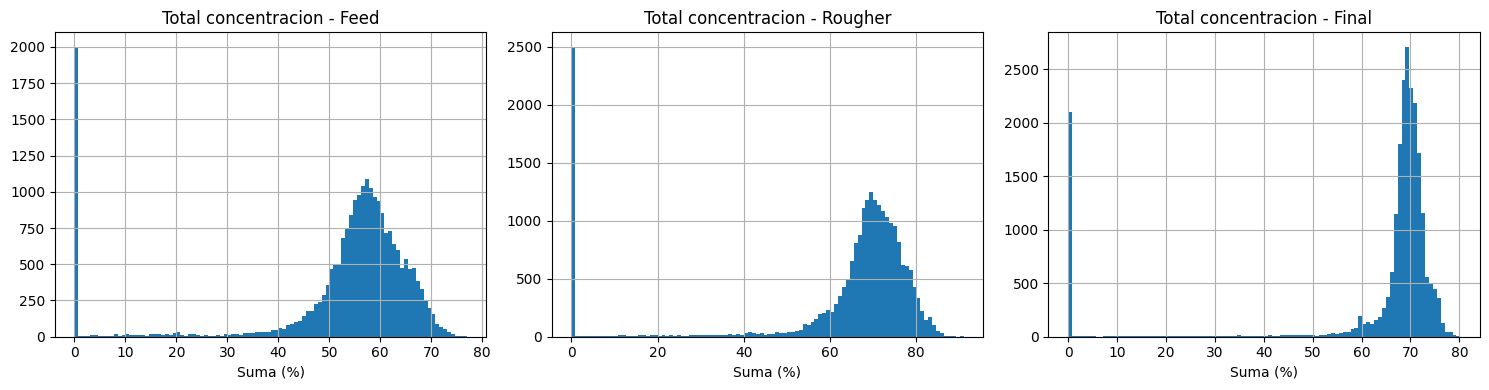

In [16]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
data_full['total_feed'].hist(bins=100)
plt.title('Total concentracion - Feed')
plt.xlabel('Suma (%)')

plt.subplot(1, 3, 2)
data_full['total_rougher'].hist(bins=100)
plt.title('Total concentracion - Rougher')
plt.xlabel('Suma (%)')

plt.subplot(1, 3, 3)
data_full['total_final'].hist(bins=100)
plt.title('Total concentracion - Final')
plt.xlabel('Suma (%)')

plt.tight_layout()
plt.show()


Feed (materia prima): concentracion total entre 40% y 80%

Rougher: concentracion entre 30% y 80%, con un pico claro cerca de 65%

Final: concentracion muy estable entre 60% y 75%

In [17]:
# Contar valores extremos sospechosos
print('Valores > 100% en cada etapa:')
print('Feed:', (data_full['total_feed'] > 100).sum())
print('Rougher:', (data_full['total_rougher'] > 100).sum())
print('Final:', (data_full['total_final'] > 100).sum())

print('\nValores < 0% en cada etapa:')
print('Feed:', (data_full['total_feed'] < 0).sum())
print('Rougher:', (data_full['total_rougher'] < 0).sum())
print('Final:', (data_full['total_final'] < 0).sum())


Valores > 100% en cada etapa:
Feed: 0
Rougher: 0
Final: 0

Valores < 0% en cada etapa:
Feed: 0
Rougher: 0
Final: 0


No se detectan valores anormales en la concentracion total de las sustancias en ninguna de las etapas.

Por tanto, no es necesario eliminar ninguna fila por esta razon.

Las distribuciones son razonables y consistentes con el proceso industrial.

## 3. Contruccion de modelo

### 3.1 Funcion para calcular el valor final de sMAPE

In [18]:
# Funcion base para calcular sMAPE
def smape(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2

    # Evitar division por cero: reemplazar ceros en el denominador por un pequeño valor
    mask = denominator != 0
    smape_values = numerator[mask] / denominator[mask]
    
    return np.mean(smape_values) * 100
    
# Funcion final con pesos: 25% rougher, 75% final
def final_smape(y_true, y_pred):
    smape_rougher = smape(y_true[:, 0], y_pred[:, 0])
    smape_final = smape(y_true[:, 1], y_pred[:, 1])
    return 0.25 * smape_rougher + 0.75 * smape_final

### 3.2 Entrenar diferentes modelos y evaluar aplicando validacion cruzada

In [19]:
# Separar features y objetivos
target_columns = ['rougher.output.recovery', 'final.output.recovery']
X = data_train.drop(columns=target_columns)
y = data_train[target_columns]

# Inicializar listas para scores
lr_scores = []
rf_scores = []

# Definir tamaño de bloque (3 folds)
sample_size = int(len(X) / 3)

# Validacion cruzada manual por bloques
for i in range(0, len(X), sample_size):
    valid_idx = list(range(i, min(i + sample_size, len(X))))
    train_idx = list(set(range(len(X))) - set(valid_idx))
    
    # Dividir datos
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    # Modelo 1: regresion lineal
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    pred_lr = lr.predict(X_valid)
    lr_scores.append(final_smape(y_valid.values, pred_lr))
    
    # Modelo 2: random forest
    rf = RandomForestRegressor(n_estimators=50, random_state=42)
    rf.fit(X_train, y_train)
    pred_rf = rf.predict(X_valid)
    rf_scores.append(final_smape(y_valid.values, pred_rf))

# Promedio final
print(f'Regresion lineal sMAPE promedio: {np.mean(lr_scores):.4f}')
print(f'Random forest sMAPE promedio: {np.mean(rf_scores):.4f}')

Regresion lineal sMAPE promedio: 9.1129
Random forest sMAPE promedio: 9.8892


### Validación cruzada y posibles mejoras

La validación cruzada manual por bloques es adecuada en este caso porque respeta la **estructura temporal** de los datos (evita mezclar observaciones de diferentes periodos).  

**Posibles mejoras:**
- **Aumentar el número de bloques (folds):** usar más divisiones permite obtener una estimación más estable del error de validación.  
- **Experimentar con más modelos:** además de Regresión Lineal y Random Forest, se podrían probar algoritmos de Gradient Boosting como **LightGBM** o **XGBoost**, que suelen tener mejor desempeño en tareas de predicción tabular.  
- **Ajustar hiperparámetros:** aplicar búsqueda en cuadrícula o aleatoria para optimizar parámetros de Random Forest (ej. `n_estimators`, `max_depth`, `min_samples_split`) puede mejorar la capacidad predictiva del modelo.  

En este análisis inicial se utilizaron configuraciones básicas para comparar enfoques, pero se reconoce que la optimización de modelos es un paso clave para mejorar el rendimiento en un escenario de producción.


In [20]:
# Reentrenar modelo con todos los datos de entrenamiento
best_model = LinearRegression()
best_model.fit(X, y)

# Asegurar que las columnas de test sean las mismas
X_test = data_test[X.columns]

# Recuperar las etiquetas reales desde data_full (que si las tiene)
y_test = data_full.loc[data_test.index, ['rougher.output.recovery', 'final.output.recovery']]

# Eliminar filas con NaN en X_test y y_test
mask = y_test.notna().all(axis=1) & X_test.notna().all(axis=1)

X_test = X_test.loc[mask]
y_test = y_test.loc[mask]

# Predecir sobre el conjunto de prueba
y_pred = best_model.predict(X_test)

# Calcular el sMAPE final
smape_prueba = final_smape(y_test.values, y_pred)

# Mostrar el resultado
print(f'sMAPE final en la muestra de prueba: {smape_prueba:.4f}')

sMAPE final en la muestra de prueba: 9.2101


Durante esta etapa se exploraron, entrenaron y evaluaron distintos modelos de regresion para predecir dos variables objetivo clave en el proceso de produccion de oro:

`rougher.output.recovery`

`final.output.recovery`

Se utilizaron dos modelos base:

Regresion lineal (LinearRegression)

Bosque aleatorio (RandomForestRegressor)

Ambos modelos fueron evaluados mediante validacion cruzada manual, aplicando la metrica personalizada sMAPE con ponderacion 25% para la recuperacion rougher y 75% para la final, de acuerdo con los criterios del proyecto.

Resultados de la comparacion

Regresion lineal obtuvo un sMAPE promedio de 9.1129

Random forest obtuvo un sMAPE promedio de 9.8892

Dado que la regresion lineal mostro un rendimiento ligeramente superior, se selecciono como el modelo final.

El modelo entrenado con todos los datos disponibles fue evaluado sobre la muestra de prueba (data_test), obteniendo un resultado final de:

**sMAPE = 9.2101**

El modelo de regresion lineal ofrece una prediccion razonablemente precisa, con un error medio absoluto simetrico cercano al 9.2%.

Esto indica que el prototipo cumple con su objetivo de predecir de forma efectiva la recuperacion de oro en las distintas etapas del proceso, y podria ser integrado como parte de una herramienta de optimizacion para la empresa.

## Conclusiones

En este proyecto se desarrollo un prototipo de modelo de machine learning para la empresa Zyfra, con el objetivo de predecir la cantidad de oro recuperado en el proceso de produccion a partir de datos industriales reales. Este modelo busca contribuir a la optimizacion de la eficiencia, reduccion de costos y eliminacion de parametros no rentables en la industria pesada.

Etapas del proyecto:

1. Preparacion y limpieza de los datos
Se analizaron tres conjuntos de datos (train, test, full), se identificaron columnas validas para el modelo, y se eliminaron filas con valores nulos en las variables criticas.

2. Analisis exploratorio
Se estudio el comportamiento de las concentraciones de metales (Au, Ag, Pb) a lo largo del proceso, se verificaron distribuciones y se descartaron valores anormales.

3. Construccion y evaluacion del modelo
Se entrenaron modelos de regresion lineal y bosque aleatorio, evaluados mediante validacion cruzada usando la metrica sMAPE personalizada, que refleja el error porcentual simetrico ponderado.

El modelo de regresion lineal fue seleccionado como el mejor, logrando un sMAPE final de 9.2101 sobre el conjunto de prueba.

El proyecto cumple exitosamente con su objetivo: entregar un prototipo funcional, preciso y listo para integrarse como parte de un sistema de monitoreo y optimizacion en plantas de procesamiento de oro.